# Machine learning for titer prediction
The proteomics data we have for isoprenol titer is extremely underutilized - I'd like to do some ML on it to see if we can learn anything about predicting titer, or about biological correlations between proteins. 

In this notebook I try to answer the question: "How many different phenotypes (proteomics profiles) can yield high-titer strains?". Another way to think about this question is: "How many peaks does our fitness landscape - as defined by proteomics - have?". 

To answer this question, I first do distance based clustering on the highest performing strains. Looking at the top 10 highest titers yields 3 different clusters of proteomics measurements. Then, I do PCA on the proteomics of a small set of high-titer strains and try to interpret the PCA weightings to characterize the different clusters.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/3800535870.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!pip install adjustText
from adjustText import adjust_text

## Import data

In [3]:
data_file = './data/normalized_proteomics_pivot.csv'
omics = pd.read_csv(data_file, index_col=0)
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


### Drop wierd runs from C3

In [4]:
omics = omics.drop(['PP_0815_PP_1317-R1_c3',
                    'PP_0815_PP_1317-R2_c3',
                    'PP_0815_PP_1317-R3_c3',
                    'PP_1317-R1_c3',
                    'PP_1317-R2_c3',
                    'PP_1317-R3_c3'
                   ]
                  )

## Merge means by replicate

### Drop rows/columns with missing data

In [5]:
omics.loc[omics['isoprenol'].isna(), 'isoprenol']
omics = omics.dropna(axis = 0, how = 'any', subset=['isoprenol'])
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


In [6]:
omics = omics.dropna(axis = 1, how = 'any')
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


### Merge by replicate

In [7]:
omics_mean = omics.copy()
omics_mean['cycle'] = [x[-1] for x in omics_mean.index.values]
omics_mean['cycle'].value_counts()
# omics_mean['line_name'] = omics_mean.apply(lambda x: x.index.values.split('-')[0], axis = 1)
omics_mean['line_name'] = [f"{x.split('-')[0]}_c{x[-1]}" for x in omics_mean.index.values]
omics_mean['is_control'] = ['ontrol' in x for x in omics_mean['line_name']]
omics_mean.loc[omics_mean['is_control'], 'line_name'] = omics_mean.loc[
    omics_mean['is_control'], 'line_name'].apply(lambda x: f'Control_c{x[-1]}')
omics_metadata = omics_mean[['cycle', 'is_control']].copy()
omics_mean = omics_mean.drop(['cycle', 'is_control'], axis = 1)

omics_mean = omics_mean.groupby('line_name').mean()
omics_mean.shape

(295, 1899)

In [8]:
print(f"Number of measurements per cycle:\n{omics_metadata['cycle'].value_counts()}")

Number of measurements per cycle:
cycle
1    387
2    192
3    186
4    183
Name: count, dtype: int64


In [9]:
protein_measurements = omics.columns[:-1]
protein_measurements.shape

(1898,)

In [10]:
X = omics[protein_measurements]
y = omics['isoprenol']
X_mean = omics_mean[protein_measurements]
y_mean = omics_mean['isoprenol']
X

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5415,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.951346,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.988927,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,1.031219,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.072695,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991063,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.742051,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.756146,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.645999,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907


In [11]:
y

line_name_rep_cycle
Control-R10_c1    1.024392
Control-R11_c1    1.120367
Control-R12_c1    1.178920
Control-R13_c1    0.720284
Control-R14_c1    1.030501
                    ...   
PP_5419-R2_c1     2.153361
PP_5419-R3_c1     2.397354
PP_5420-R1_c1     0.484521
PP_5420-R2_c1     0.527125
PP_5420-R3_c1     0.556424
Name: isoprenol, Length: 948, dtype: float64

In [12]:
omics_index = omics.index.values
cycle_label = [int(x[-1]) for x in omics_index]
num_grna = [x.count('PP') for x in omics_index]
is_control = [1 if 'ontrol' in x else 0 for x in omics_index]

### Scale data for ML

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm
X_norm_df = X.copy()
X_norm_df.iloc[:,:] = X_norm
X_norm_df

scaler2 = StandardScaler()
X_mean_norm = scaler2.fit_transform(X_mean)
X_mean_norm_df = X_mean.copy()
X_mean_norm_df.iloc[:,:] = X_mean_norm

## "Machine learning"
Want to try some basic sklearn on the data.

### PCA on individual replicates
See how well PCA can fit the data (how many components required) and whether PCA shows any obvious patterns with titer.

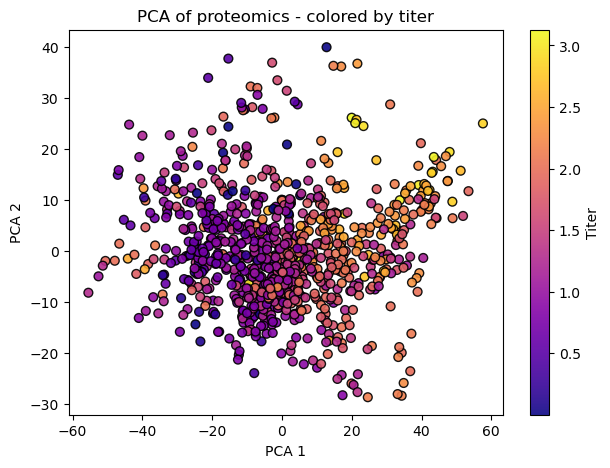

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X_norm)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y, s = 40, alpha = 0.9, edgecolors='k', cmap = 'plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
cbar = plt.colorbar(label = 'Titer')
# cbar.ax.set_ylabel('Titer')

plt.title('PCA of proteomics - colored by titer')
fig.savefig('./figures/PCA_colored_by_titer.png')

In [15]:
X_pca.shape

(948, 10)

#### Coloring PCA by different descriptors
Does PCA tell us anything about:
- titer: no prior expectation
- cycle: Hopefully the cycles are all overlapping to some extent - otherwise there's a proteomic signature between cycles that could be confounding.
- num_grna: Hopefully these all overlap
- controls: Hopefully the controls from all cycles overlap

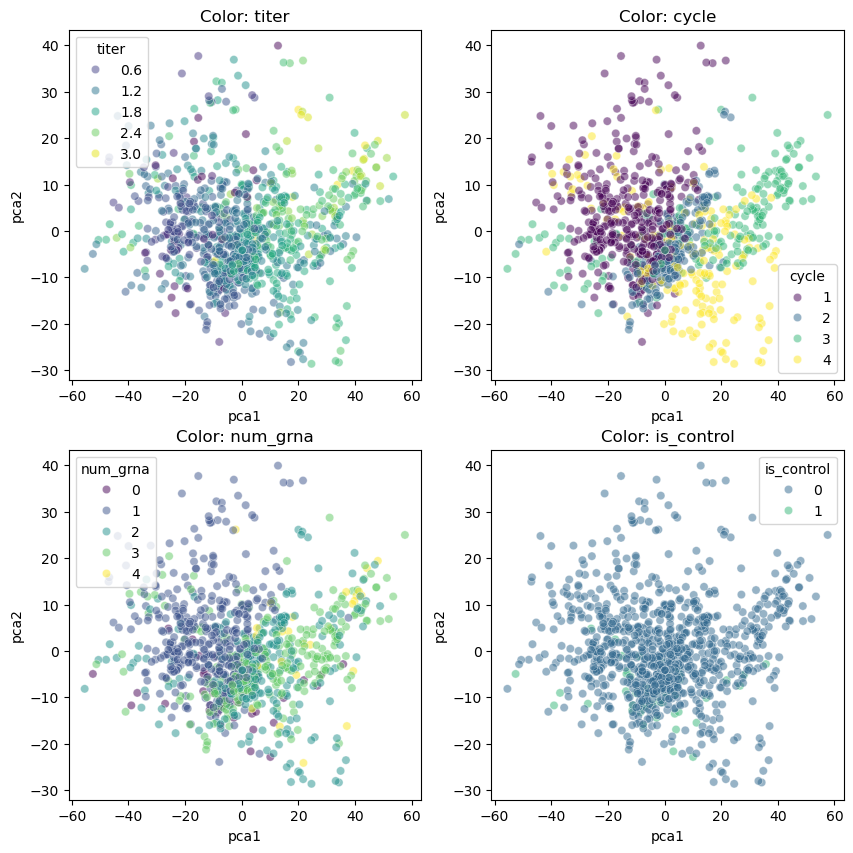

In [16]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(pca1 = X_pca[:,0], pca2 = X_pca[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'pca1', y = 'pca2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')
    

#### Looking at explained variance

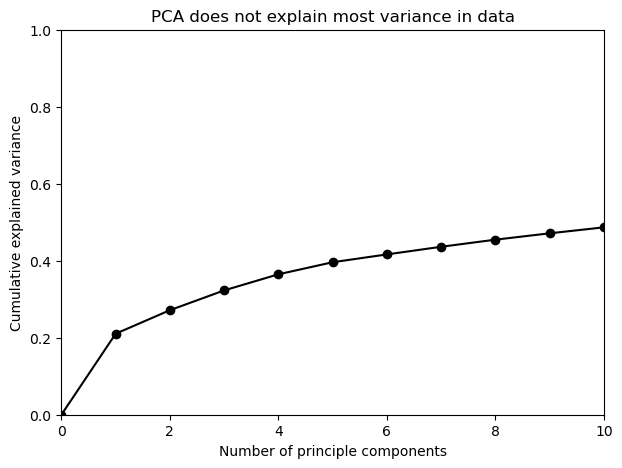

In [17]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PCA does not explain most variance in data')
fig.savefig('./figures/PCA_var_exp.png')

### Exploring differences between cycles
PCA shows that the first PCA dimension fully separates the two cycles. What variables are most associated with PC1?

In [18]:
weights = pca.components_
weights.shape

(10, 1898)

In [19]:
weights_df = pd.DataFrame(dict(ft = protein_measurements, pca1 = weights[0,:], pca2 = weights[1,:]))
weights_df

,ft,pca1,pca2
0,MM_1762,0.021882,-0.012987
1,PP_0001,0.020210,-0.016306
2,PP_0002,0.018231,-0.023588
3,PP_0003,0.032358,-0.016888
4,PP_0004,0.018262,-0.008172
...,...,...,...
1893,YNR043W,0.012575,-0.010862
1894,aacC1,0.007140,-0.051970
1895,b4055 JW4015,0.018627,0.003294
1896,mvaS,0.022684,-0.009518


identify top 10 PC1 components

In [20]:
top_10_pc1 = weights_df.sort_values(by='pca1', ascending = False)['ft'].head(10)
top_10_pc1

1035    PP_2488
1332    PP_4200
323     PP_0759
750     PP_1702
30      PP_0072
1258    PP_3922
688     PP_1529
1829    PP_5283
1685    PP_4998
875     PP_2017
Name: ft, dtype: object

In [21]:
df_top10pcs = X_norm_df.loc[:, top_10_pc1]
df_top10pcs['cycle'] = [int(x[-1]) for x in df_top10pcs.index]

In [22]:
df_top10pcs

,PP_2488,PP_4200,PP_0759,PP_1702,PP_0072,PP_3922,PP_1529,PP_5283,PP_4998,PP_2017,cycle
line_name_rep_cycle,,,,,,,,,,,
Control-R10_c1,-0.307554,-0.510067,0.238004,0.230037,0.349966,0.467639,-0.245837,-0.344714,0.177676,-0.311034,1
Control-R11_c1,-0.319386,-0.124908,-0.503563,0.499012,0.133610,-0.139694,-0.217079,-0.214105,0.097543,0.191274,1
Control-R12_c1,-0.242613,-0.083590,-0.285346,0.176140,0.190203,-0.159579,0.263282,0.131901,0.369216,0.170735,1
Control-R13_c1,-0.564583,-0.104540,-0.219650,0.122777,0.185130,-0.058582,0.073078,0.203978,0.821373,-0.375716,1
Control-R14_c1,-0.696162,-0.258976,-0.241484,0.197755,0.388595,-0.151000,-0.233176,0.457094,0.507201,-0.265032,1
...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.130735,0.436336,0.246108,-0.448138,0.302385,0.381194,0.659247,1.956087,-0.129307,3.724405,1
PP_5419-R3_c1,0.569347,0.346702,0.234214,-0.366643,1.131752,0.629697,0.889052,1.788386,-0.242236,4.505305,1
PP_5420-R1_c1,-0.906598,0.643511,0.023833,-0.899840,-1.247424,0.039010,-1.226504,0.044100,-1.410413,-1.094531,1


#### Plot proteins that change most across cycles according to PCA

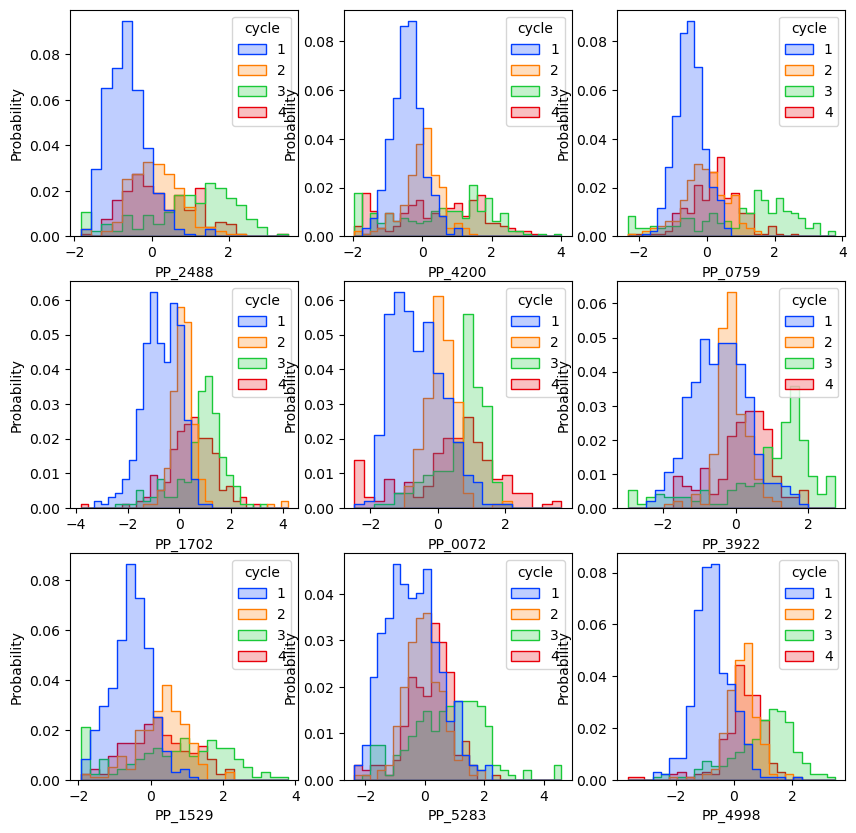

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (10,10))

for idx, axis in enumerate(fig.axes):
    sns.histplot(df_top10pcs, x = top_10_pc1.iloc[idx], hue = 'cycle', ax = axis, stat='probability', common_bins = True, element = 'step', palette='bright')


## Nonlinear dimensionality reduction - TSNE
t-SNE is a nonlinear dimensionality reduction technique. We can use it to ask the same questions as PCA.

In [24]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, learning_rate='auto', init = 'random', perplexity = 10).fit_transform(X_norm)


### Plot tSNE results
Note that high-titer strains (top-left plot, light green/yellow points) appear in multiple clusters. 

The controls also cluster together really nicely (bottom right graph)

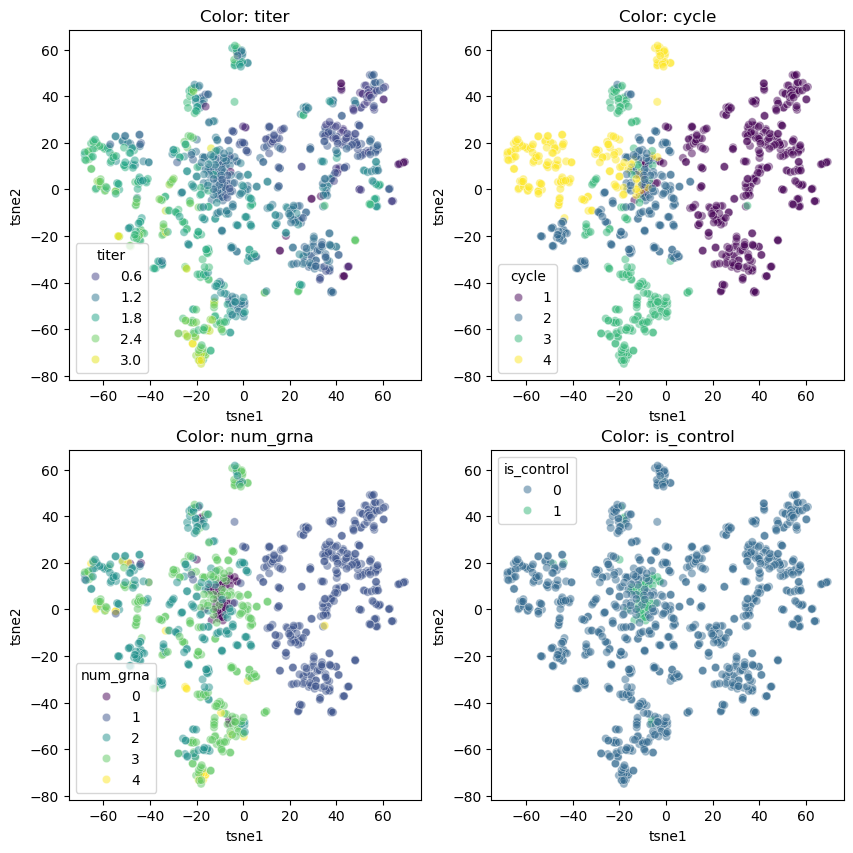

In [25]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(tsne1 = X_tsne[:,0], tsne2 = X_tsne[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'tsne1', y = 'tsne2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

#### Varying t-SNE perplexity
There is a hyperparameter for t-SNE - perplexity - that determines how the dimensionality reduction works. Our key observation - that high-titer strains don't all cluster together - seems to be robust to changing perplexity.

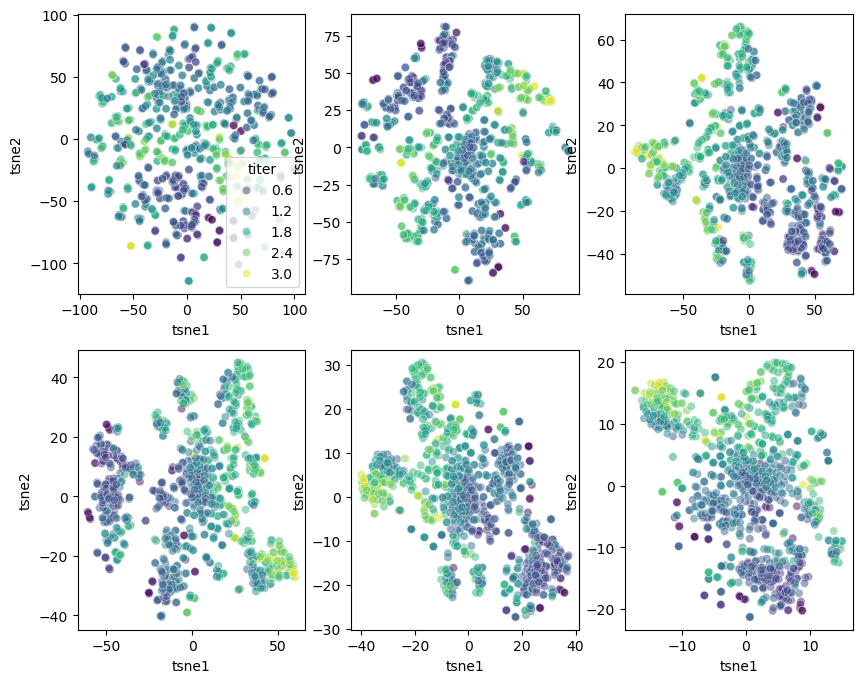

In [26]:
perplexity_vector = [2,5,10,20,50,100]
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10,8))
for i, ax in enumerate(fig.get_axes()):
    X_tsne = TSNE(n_components=2, learning_rate='auto', init = 'random',
                  perplexity = perplexity_vector[i]).fit_transform(X_norm)

    df_plot = pd.DataFrame(dict(tsne1 = X_tsne[:,0], tsne2 = X_tsne[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))
    sns.scatterplot(df_plot, x = 'tsne1', y = 'tsne2', hue = 'titer', palette = 'viridis', ax = ax, alpha = 0.5)
    axis.set_title(f'Perplexity = {perplexity_vector[i]}')
    if i != 0:
        ax.legend([],[], frameon=False)

### Spectral embedding
These are other dimensionality reduction techniques - not super useful I think.

```
>>> from sklearn.datasets import load_digits
>>> from sklearn.manifold import SpectralEmbedding
>>> X, _ = load_digits(return_X_y=True)
>>> X.shape
(1797, 64)
>>> embedding = SpectralEmbedding(n_components=2)
>>> X_transformed = embedding.fit_transform(X[:100])
>>> X_transformed.shape
(100, 2)
```

In [27]:
from sklearn.manifold import SpectralEmbedding, Isomap


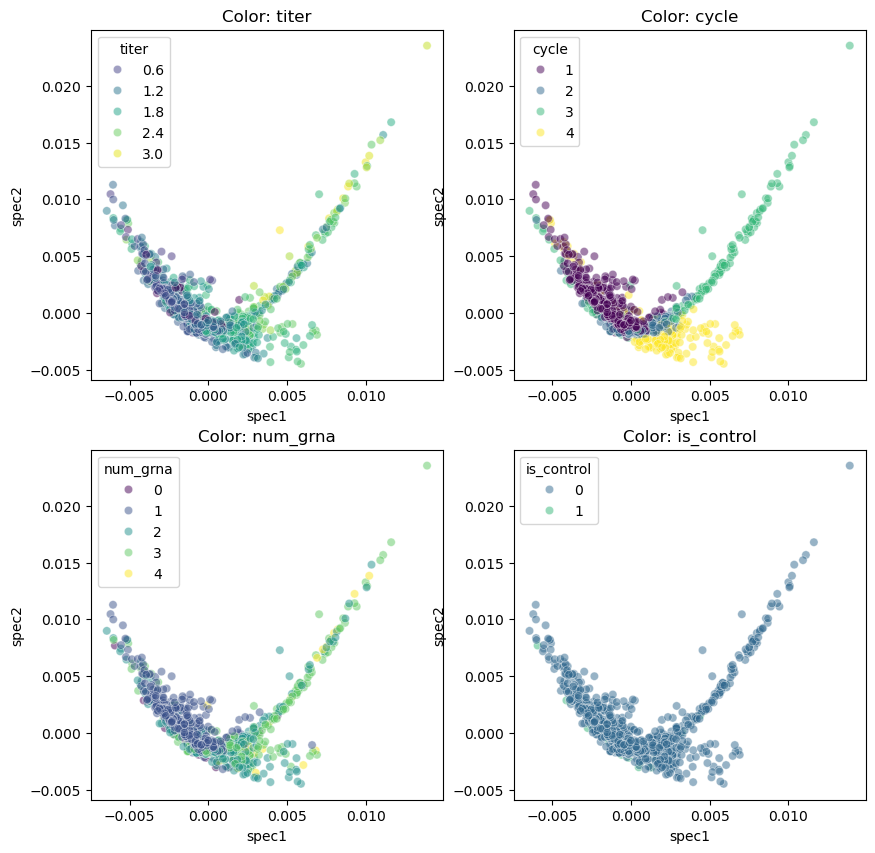

In [28]:
X_spec = SpectralEmbedding(n_components=2,affinity='rbf').fit_transform(X_norm)
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(spec1 = X_spec[:,0], spec2 = X_spec[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'spec1', y = 'spec2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

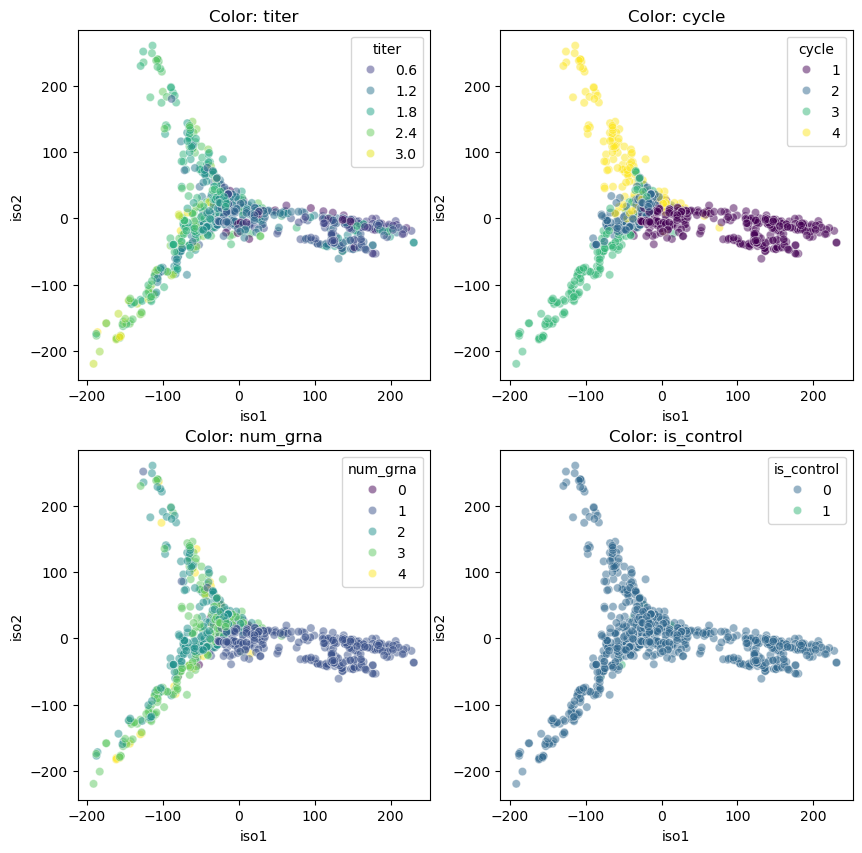

In [29]:
X_iso = Isomap(n_components=2).fit_transform(X_norm)
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(iso1 = X_iso[:,0], iso2 = X_iso[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'iso1', y = 'iso2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

## Distance distributions

After showing that high-titer strains are distant from one another using dimensionality reduction, now we look at the actual distribution of distances.

Look at the distance between all strains, high-titer strains, all strains to controls, and high-titer strains to controls

Use argpartition to get highest titers

In [30]:
n_high = 15
high_idx = np.argpartition(y, -n_high)[-n_high:]
high_values = y[high_idx]
high_idx

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/2215053554.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values = y[high_idx]


array([208, 259, 257, 255, 308, 327, 329, 331, 186, 187, 522, 188, 526,
       221, 219])

In [31]:
from scipy.spatial.distance import squareform, pdist

In [32]:
len(is_control)
X_norm.shape

(948, 1898)

Text(0.5, 0, 'Distribution of proteomics distances between strains')

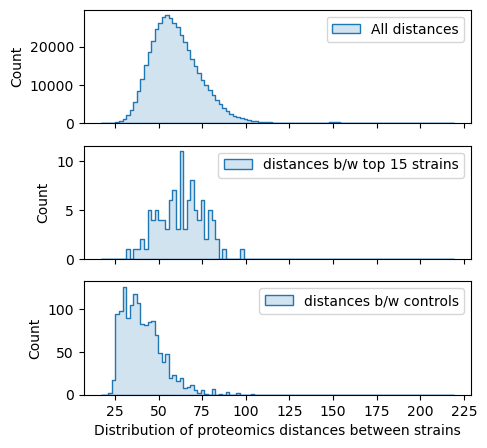

In [33]:
d_all = pdist(X_norm)
d_top = pdist(X_norm[high_idx,:])
d_ctrl = pdist(X_norm[np.where(is_control)[0],:])
bins = np.linspace(0.8*d_all.min(), 1.2*d_all.max(), 100)
fig, ax = plt.subplots(figsize = (5,5), nrows = 3, sharex = True)
sns.histplot(data=d_all, stat = 'count', bins=bins, alpha = 0.2, label = 'All distances', ax = ax[0], element = 'step')
sns.histplot(data = d_top, stat = 'count', bins = bins, alpha = 0.2, label = f'distances b/w top {n_high} strains', ax = ax[1], element = 'step')
sns.histplot(data = d_ctrl, stat = 'count', bins = bins, alpha = 0.2, label = f'distances b/w controls', ax = ax[2], element = 'step')
for a in ax:
    a.legend()
ax[-1].set_xlabel('Distribution of proteomics distances between strains')
# plt.legend(['All distances', f'distances b/w top {n_high} strains'])


### Distance distribution heatmap
Make a heatmap showing the distances between all of the high-titer strains (and including a few controls).

Observations: 

- All the controls cluster together (good).
- Replicates don't necessarily cluster together (messy).
- There are maybe 4 clusters and a few random individuals within the data.

/Users/pckinnunen/miniforge3/envs/sci_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/pckinnunen/miniforge3/envs/sci_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


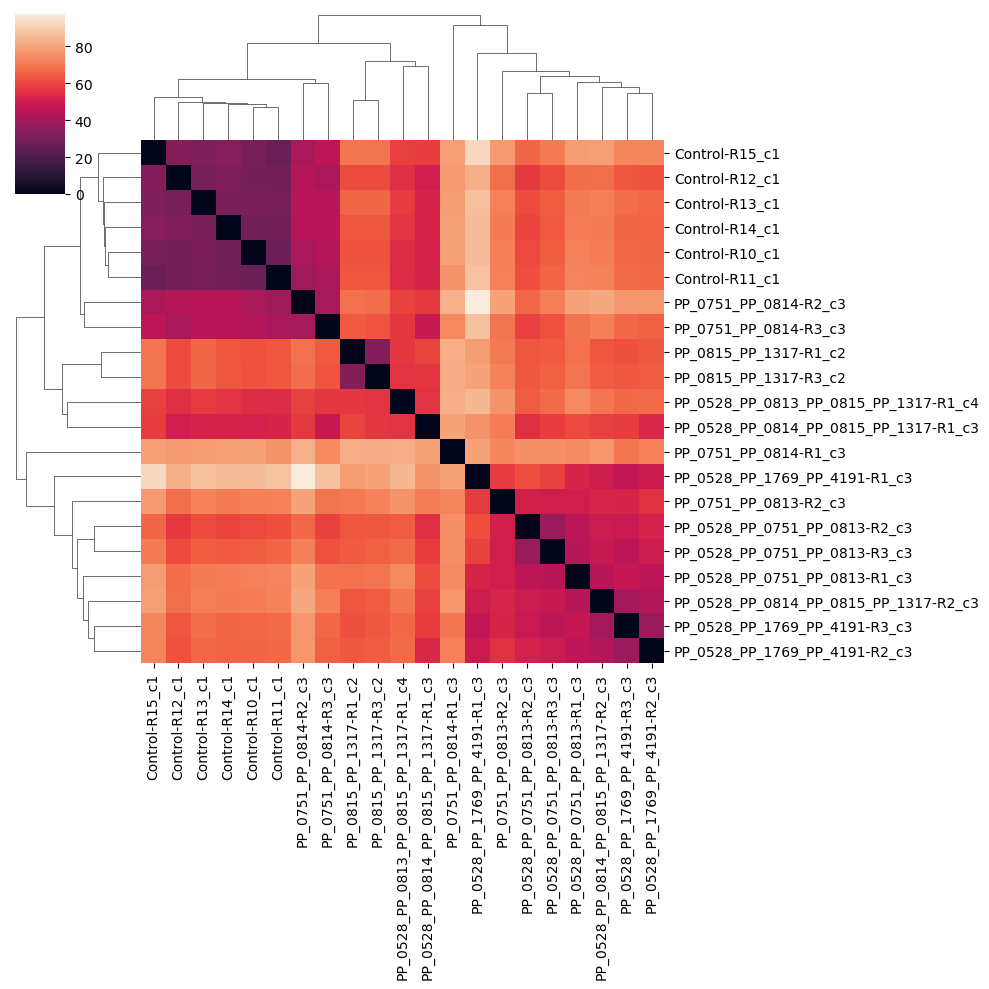

In [34]:
control_idx = np.where(is_control)[0][:6]
plot_idx = np.hstack([control_idx, high_idx])
# plot_idx = high_idx
high_dmat = squareform(pdist(X_norm[plot_idx,:]))
high_dist_df = pd.DataFrame(data = high_dmat, columns = X.index.values[plot_idx], index = X.index.values[plot_idx])
sns.clustermap(data = high_dist_df)

### Repeat heatmap with replicate-averaged data

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/2155988702.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/Users/pckinnunen/miniforge3/envs/sci_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/pckinnunen/miniforge3/envs/sci_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


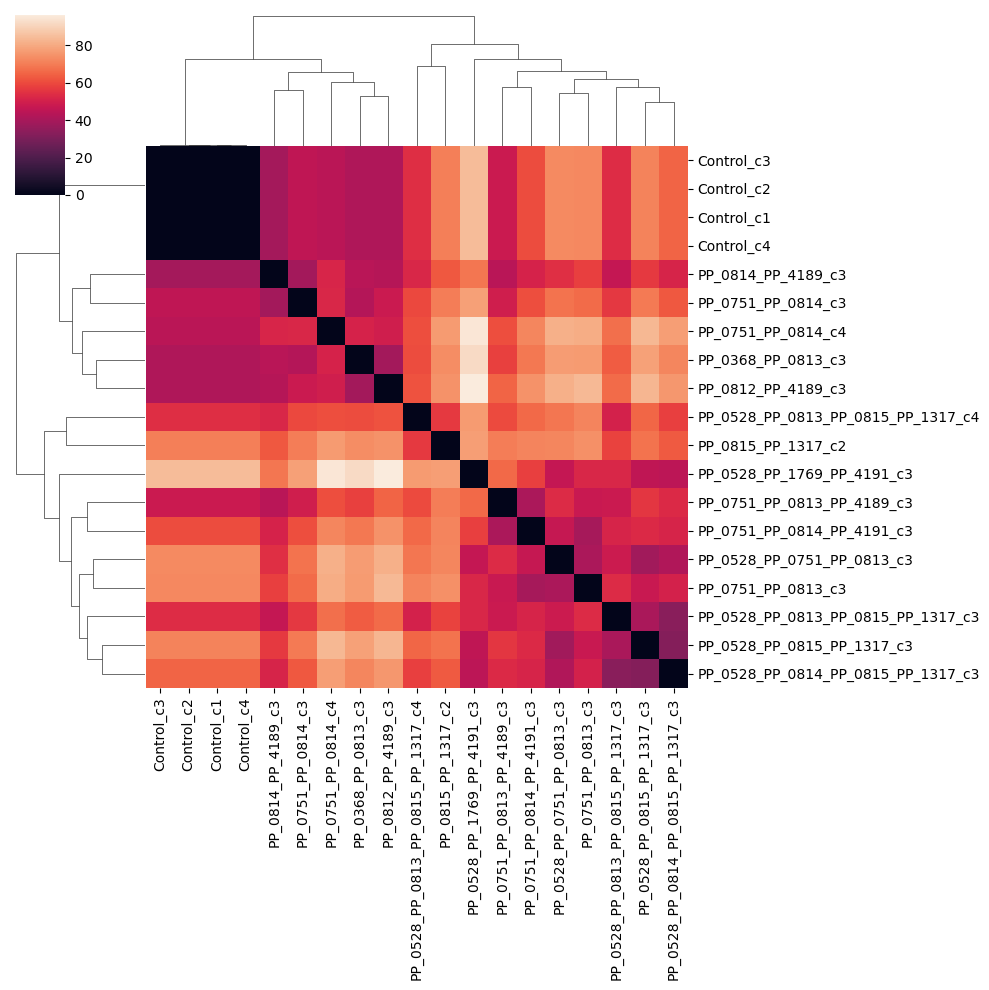

In [35]:
n_high = 15
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
# plot_idx = high_idx
high_dmat = squareform(pdist(X_mean_norm[plot_idx,:]))


high_dist_df = pd.DataFrame(data = high_dmat, columns = X_mean.index.values[plot_idx], index = X_mean.index.values[plot_idx])
sns.clustermap(data = high_dist_df)



## Coloring my data by titer-category

Can add a color to each row/column in the clustergram indicating some other variable - here I'll use titer

### First, get data
Pick `n_high` highest titer strains controls and get their idx

In [36]:
n_high = 20
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]
print(f'idx of high titer: {high_idx}')

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
high_dmat = squareform(pdist(X_mean_norm[plot_idx,:]))

idx of high titer: [208 259 257 255 308 327 329 331 186 187 522 188 526 221 219]


/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/3763712076.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]


In [37]:
control_idx

array([0, 1, 2, 3, 4, 5])

In [38]:
control_idx_mean

array([0, 1, 2, 3])

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/3594566386.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/3594566386.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(np.mean(y_mean[control_idx_mean]), c = 'r', linestyle = '--', label = 'Control')


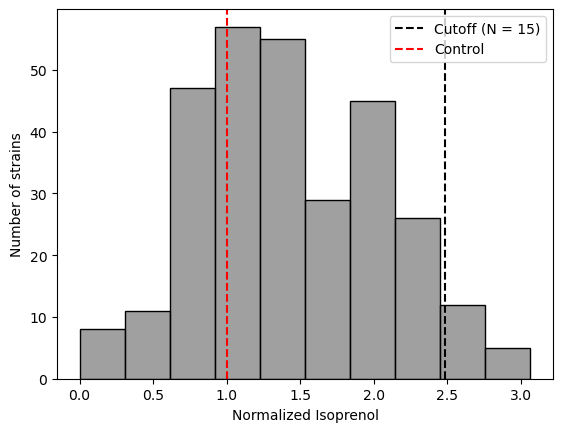

In [39]:
N_HIGH = 15
n_high = N_HIGH
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

fig, ax = plt.subplots()
sns.histplot(
    data = y_mean,
    ax = ax,
    color = 'grey' 
)
ax.set_xlabel('Normalized Isoprenol')
ax.set_ylabel('Number of strains')
ax.axvline(np.min(high_values_mean), c= 'k', linestyle = '--', label = f'Cutoff (N = {N_HIGH})')
ax.axvline(np.mean(y_mean[control_idx_mean]), c = 'r', linestyle = '--', label = 'Control')
ax.legend()

In [40]:
import matplotlib as mpl
from matplotlib import cm

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/2386731771.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/2386731771.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  titer_category_df = pd.DataFrame(y_mean[plot_idx])
/Users/pckinnunen/miniforge3/envs/sci_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.metho

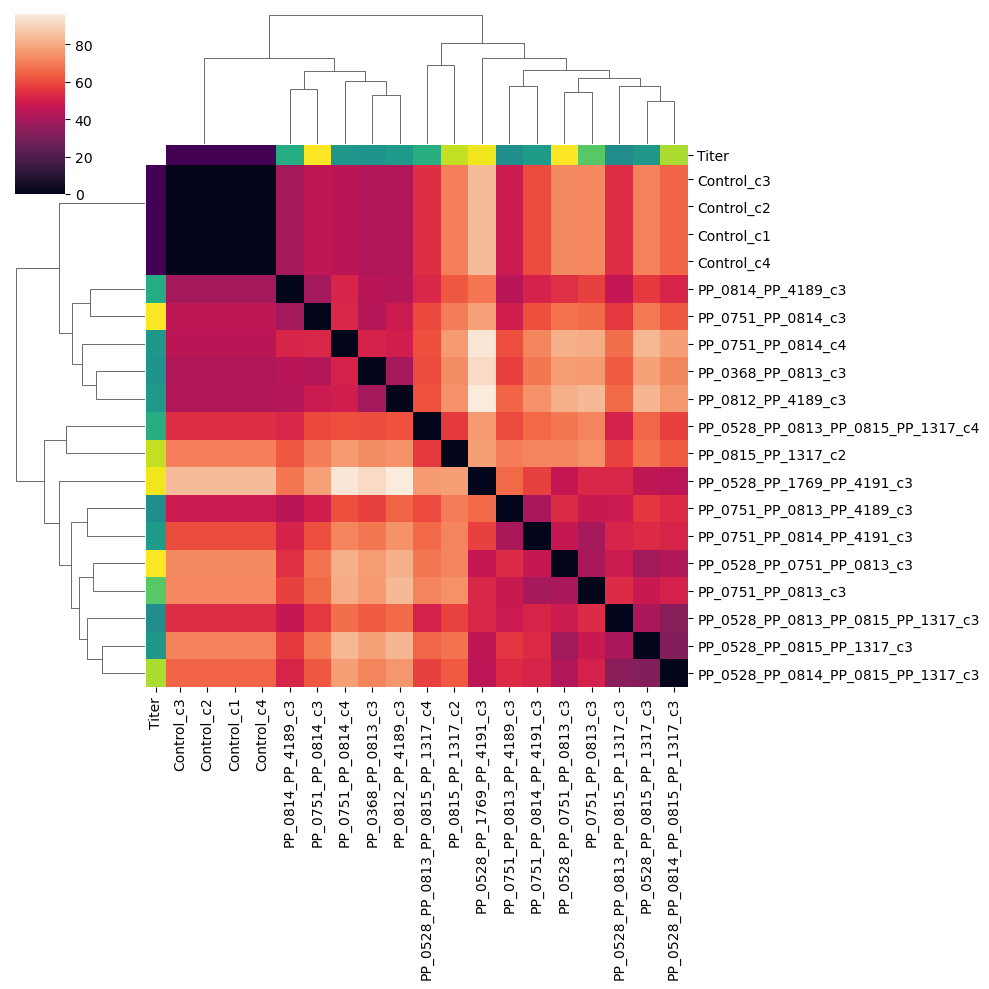

In [41]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
high_dmat = squareform(pdist(X_mean_norm[plot_idx,:]))

titer_category_df = pd.DataFrame(y_mean[plot_idx])

scalar_map = cm.ScalarMappable(
    norm = mpl.colors.Normalize(vmin =2, vmax = 3),
    cmap = plt.get_cmap('viridis'),
)

titer_category_df.loc[:,'c_cont'] = titer_category_df['isoprenol'].apply(lambda x: scalar_map.to_rgba(x))
titer_colors = pd.Series(titer_category_df.loc[:,'c_cont'])
titer_colors.name = 'Titer'
titer_colors.head(4)

high_dist_df = pd.DataFrame(data = high_dmat, columns = X_mean.index.values[plot_idx], index = X_mean.index.values[plot_idx])
c = sns.clustermap(data = high_dist_df, 
                   row_colors = titer_colors, 
                   col_colors=titer_colors
                  )

## Replicate clustering
Here, I expand the funcitonality of the code by creating my own distance linkage (using scipy builtins) - therefore I can work with the clustering after I make the plot.

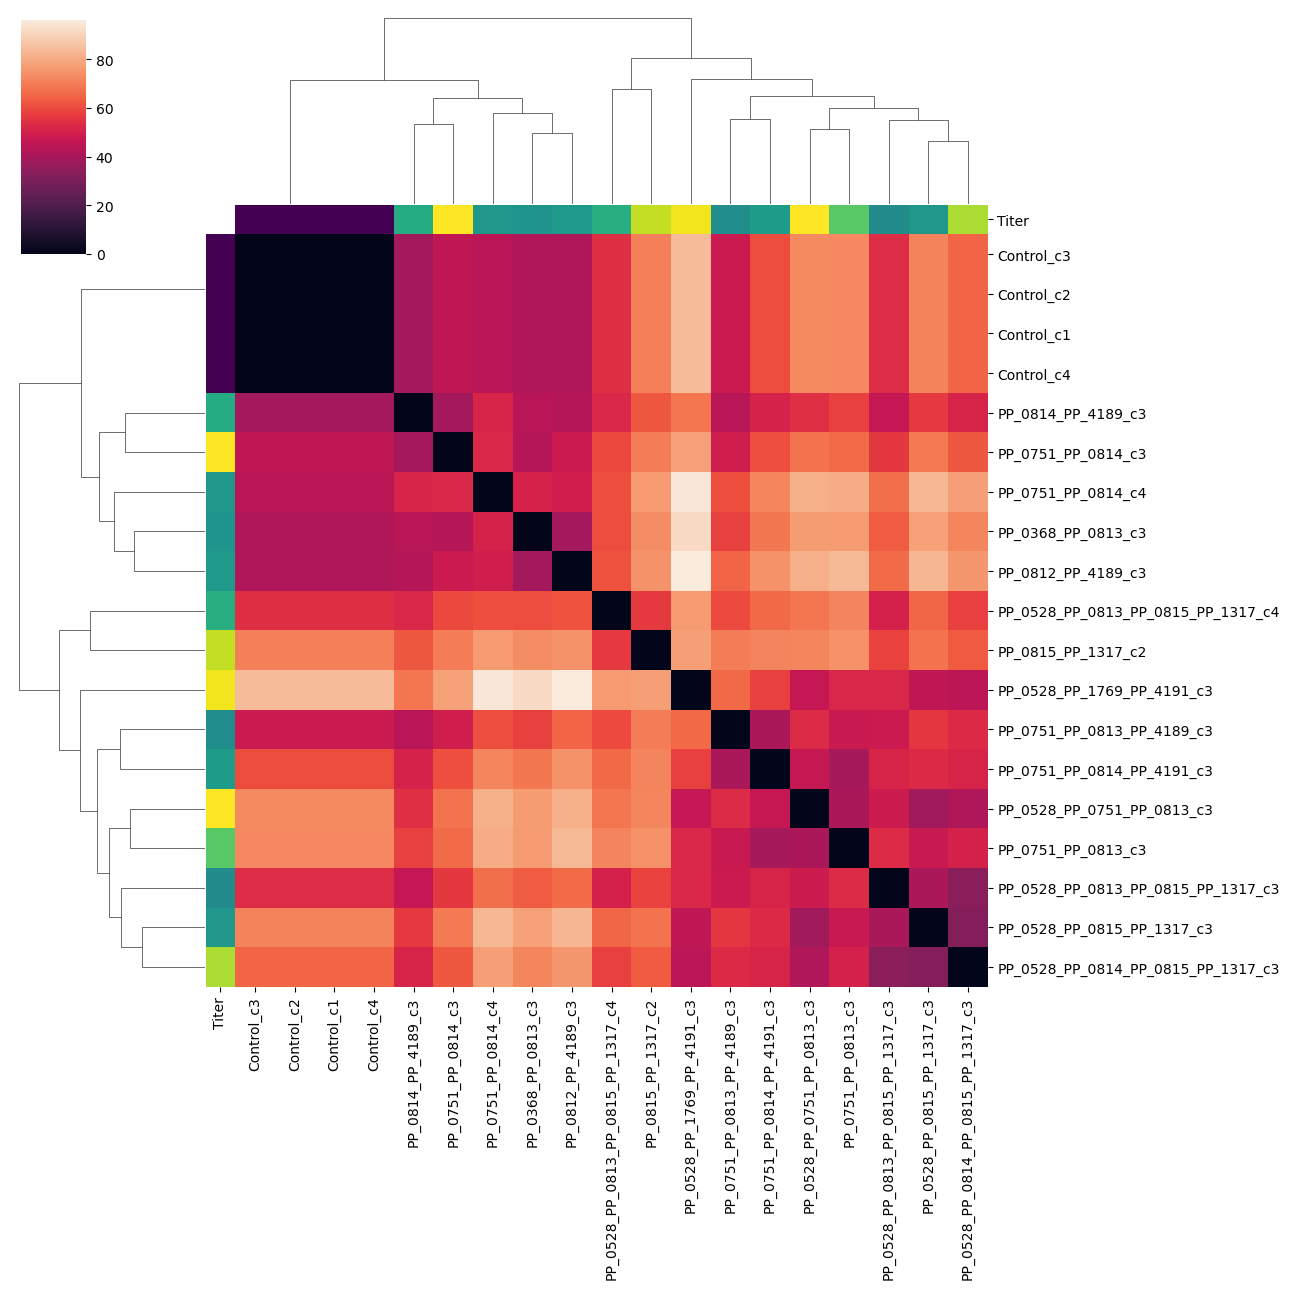

In [42]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

dist_linkage = hierarchy.linkage(
    distance.pdist(high_dist_df), method='average')

sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=titer_colors,
               method="average",
               col_colors=titer_colors,
               figsize=(13, 13)
              )

### Demonstrate that clustering works
Here I color each strain by the assigned cluster to check that it's working.

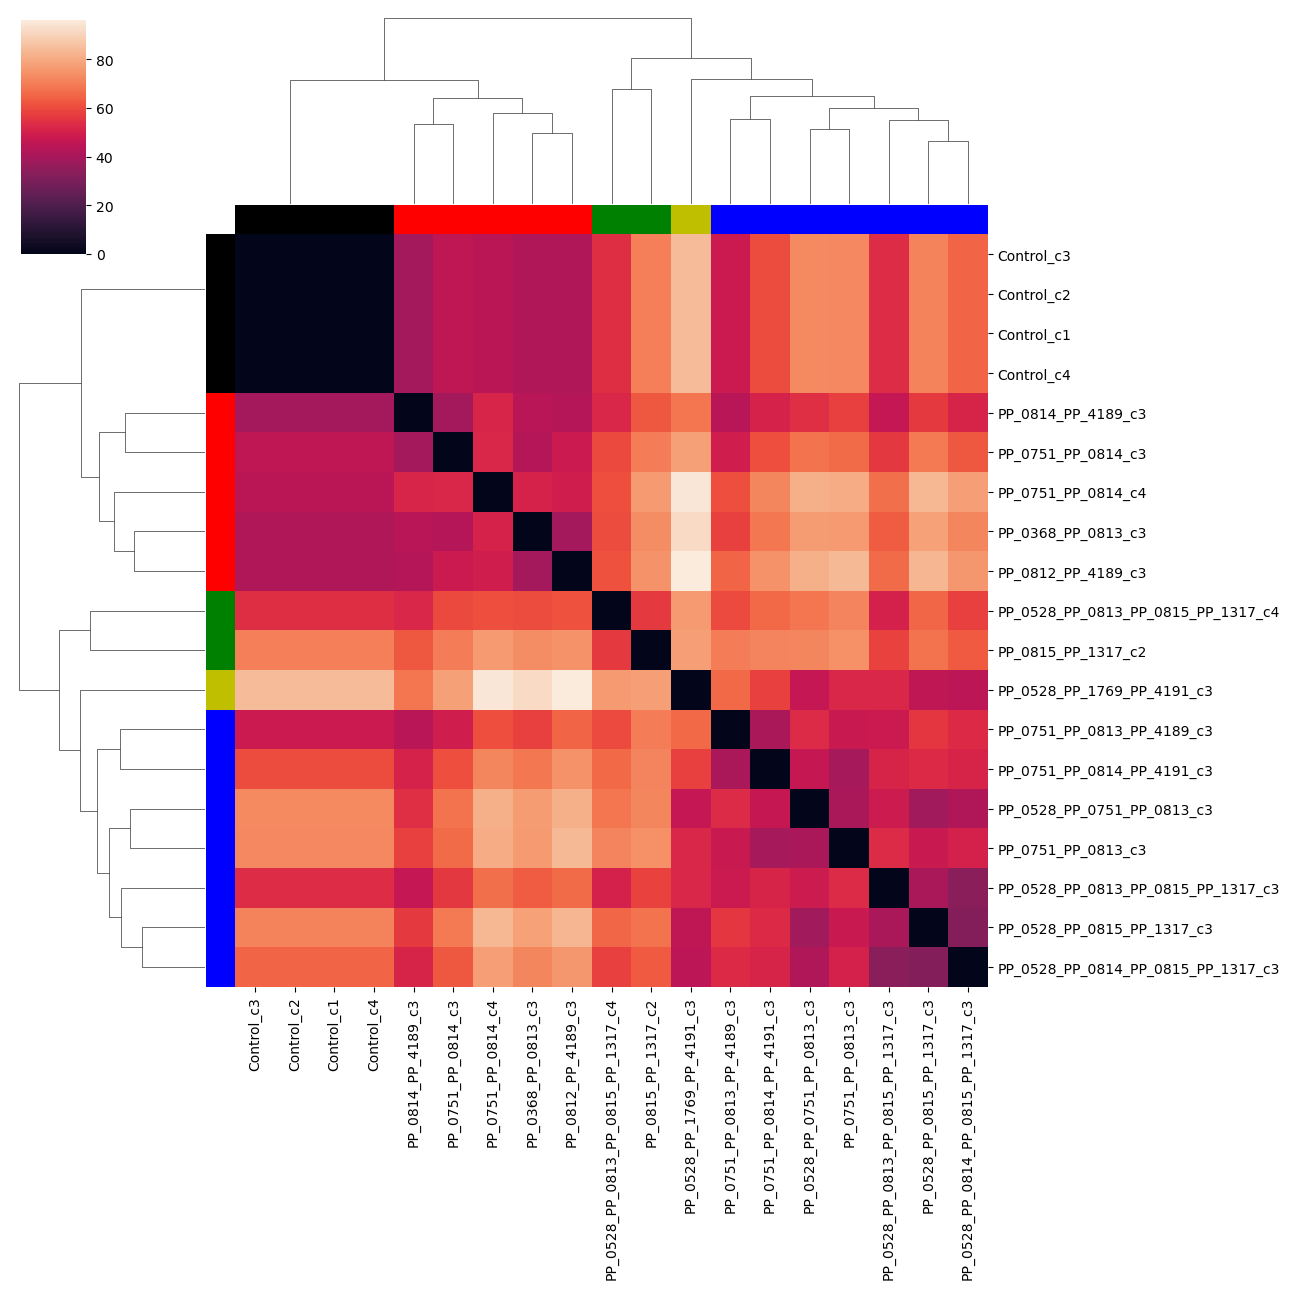

In [43]:
fc = hierarchy.fcluster(dist_linkage, t = 5, criterion='maxclust')
fc
c_all = 'krgby'
fc_color = [c_all[int(x-1)] for x in fc]
sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=fc_color,
               method="average",
               col_colors=fc_color,
               figsize=(13, 13)
              )

### Do PCA on clustered high-titer strains

In [44]:
cluster_df = high_dist_df.copy()
cluster_df['cluster'] = fc
cluster_df

,Control_c1,Control_c2,Control_c3,Control_c4,PP_0528_PP_0813_PP_0815_PP_1317_c3,PP_0751_PP_0813_PP_4189_c3,PP_0368_PP_0813_c3,PP_0751_PP_0814_c4,PP_0528_PP_0815_PP_1317_c3,PP_0812_PP_4189_c3,PP_0814_PP_4189_c3,PP_0751_PP_0814_PP_4191_c3,PP_0528_PP_0813_PP_0815_PP_1317_c4,PP_0528_PP_1769_PP_4191_c3,PP_0528_PP_0751_PP_0813_c3,PP_0751_PP_0813_c3,PP_0528_PP_0814_PP_0815_PP_1317_c3,PP_0815_PP_1317_c2,PP_0751_PP_0814_c3,cluster
Control_c1,0.000000e+00,1.524708e-14,1.488662e-14,1.394677e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c2,1.524708e-14,0.000000e+00,1.995948e-14,2.030575e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c3,1.488662e-14,1.995948e-14,0.000000e+00,1.945751e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c4,1.394677e-14,2.030575e-14,1.945751e-14,0.000000e+00,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
PP_0528_PP_0813_PP_0815_PP_1317_c3,5.341816e+01,5.341816e+01,5.341816e+01,5.341816e+01,0.000000,47.810019,63.411959,67.141058,40.279962,66.257773,46.187796,51.044838,50.353732,51.938837,48.314872,53.085417,33.341206,58.309101,56.123516,4
PP_0751_PP_0813_PP_4189_c3,4.791116e+01,4.791116e+01,4.791116e+01,4.791116e+01,47.810019,0.000000,57.975739,60.623791,55.727712,64.639855,43.641511,40.720837,59.990491,65.758367,52.952913,47.633399,52.573154,69.971985,49.485047,4
PP_0368_PP_0813_c3,4.157299e+01,4.157299e+01,4.157299e+01,4.157299e+01,63.411959,57.975739,0.000000,50.718574,77.698898,38.895133,43.833117,69.008455,60.340924,91.565777,76.907585,76.414620,71.745845,73.195647,42.532621,2
PP_0751_PP_0814_c4,4.397498e+01,4.397498e+01,4.397498e+01,4.397498e+01,67.141058,60.623791,50.718574,0.000000,83.011049,49.220612,51.748930,72.049081,60.694941,94.640094,81.064321,80.440014,77.234798,76.367455,51.999600,2
PP_0528_PP_0815_PP_1317_c3,7.105372e+01,7.105372e+01,7.105372e+01,7.105372e+01,40.279962,55.727712,77.698898,83.011049,0.000000,82.782327,56.305139,52.559348,65.177660,45.183780,38.352979,47.484605,32.181429,67.742477,69.057976,4
PP_0812_PP_4189_c3,4.133653e+01,4.133653e+01,4.133653e+01,4.133653e+01,66.257773,64.639855,38.895133,49.220612,82.782327,0.000000,43.105034,74.571462,61.406890,96.066890,81.195244,83.375592,75.746419,74.533875,47.899857,2


In [45]:
X_cluster_df = X_mean_norm_df.iloc[plot_idx,:].copy()
X_cluster_df['cluster'] = cluster_df['cluster']
X_cluster_df['isoprenol'] = pd.Series(y_mean[plot_idx])
X_cluster_df

/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/685606278.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_cluster_df['isoprenol'] = pd.Series(y_mean[plot_idx])


,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,cluster,isoprenol
line_name,,,,,,,,,,,,,,,,,,,,,
Control_c1,0.050349,0.047709,0.412712,0.408227,0.438694,-0.252177,0.539028,0.329488,0.176232,0.443351,...,-0.150816,0.038666,0.575342,-0.100951,0.062246,-0.175852,-0.250213,0.091312,1,1.000000
Control_c2,0.050349,0.047709,0.412712,0.408227,0.438694,-0.252177,0.539028,0.329488,0.176232,0.443351,...,-0.150816,0.038666,0.575342,-0.100951,0.062246,-0.175852,-0.250213,0.091312,1,1.000000
Control_c3,0.050349,0.047709,0.412712,0.408227,0.438694,-0.252177,0.539028,0.329488,0.176232,0.443351,...,-0.150816,0.038666,0.575342,-0.100951,0.062246,-0.175852,-0.250213,0.091312,1,1.000000
Control_c4,0.050349,0.047709,0.412712,0.408227,0.438694,-0.252177,0.539028,0.329488,0.176232,0.443351,...,-0.150816,0.038666,0.575342,-0.100951,0.062246,-0.175852,-0.250213,0.091312,1,1.000000
PP_0528_PP_0813_PP_0815_PP_1317_c3,0.246952,-0.313227,0.398980,1.376885,1.960041,0.435380,0.149352,-0.696072,0.777109,0.958463,...,-0.508107,0.029285,1.016148,0.174148,-0.212448,0.871708,0.908953,0.115772,4,2.483199
PP_0751_PP_0813_PP_4189_c3,0.148680,1.915784,0.497376,1.733173,0.776367,0.744367,1.025946,-0.864571,1.518917,0.706079,...,0.149790,-0.009827,-0.301836,-0.284949,-0.012553,-0.306705,-0.288414,-0.146668,4,2.491773
PP_0368_PP_0813_c3,1.206752,-1.474558,-0.339536,-0.090612,1.405507,0.486765,1.671228,-0.673335,0.342642,0.326217,...,2.278437,0.069960,0.772440,0.276800,-0.242175,-0.619207,0.518253,-0.766374,2,2.516533
PP_0751_PP_0814_c4,-1.417182,-1.278178,-1.961320,-0.160894,0.173946,-0.678682,0.523097,-0.168117,-0.967084,0.036960,...,0.636247,0.238401,0.934415,-1.408686,2.250345,-1.229958,0.375973,-1.684129,2,2.528674
PP_0528_PP_0815_PP_1317_c3,1.308248,1.161866,1.252564,2.030627,2.014773,0.912415,0.144935,-0.671406,0.403512,1.069931,...,0.825762,-0.155009,0.535165,0.381341,0.130198,1.255909,2.422444,0.012301,4,2.530151


In [46]:
X_cluster_df['cluster'].sort_values()

line_name
Control_c1                            1
Control_c2                            1
Control_c3                            1
Control_c4                            1
PP_0814_PP_4189_c3                    2
PP_0751_PP_0814_c4                    2
PP_0812_PP_4189_c3                    2
PP_0368_PP_0813_c3                    2
PP_0751_PP_0814_c3                    2
PP_0815_PP_1317_c2                    3
PP_0528_PP_0813_PP_0815_PP_1317_c4    3
PP_0751_PP_0813_PP_4189_c3            4
PP_0528_PP_0815_PP_1317_c3            4
PP_0528_PP_0813_PP_0815_PP_1317_c3    4
PP_0751_PP_0814_PP_4191_c3            4
PP_0528_PP_0751_PP_0813_c3            4
PP_0751_PP_0813_c3                    4
PP_0528_PP_0814_PP_0815_PP_1317_c3    4
PP_0528_PP_1769_PP_4191_c3            5
Name: cluster, dtype: int32

In [47]:
import re
from collections import Counter

In [48]:
test = 'PP_0528_PP_0815_PP_1317_c3'
re.findall('PP_[0-9]{4}', test)
# test.split('_')[:-1]

['PP_0528', 'PP_0815', 'PP_1317']

In [49]:
cluster_df_target = X_cluster_df['cluster'].sort_values().copy().reset_index(drop = False)
cluster_df_target['is_control'] = cluster_df_target['line_name'].apply(lambda x: 'ontrol' in x)

cluster_df_target

n_clusters = cluster_df_target['cluster'].max()
target_cluster_list = [[] for _ in range(n_clusters)]
for idx, srs in cluster_df_target.iterrows():
    cluster = srs['cluster']
    targets = re.findall('PP_[0-9]{4}', srs['line_name'])
    [target_cluster_list[cluster-1].append(target) for target in targets]

counted_targets = [Counter(cluster_list) for cluster_list in target_cluster_list]
counted_targets

[Counter(),
 Counter({'PP_0814': 3,
          'PP_4189': 2,
          'PP_0751': 2,
          'PP_0812': 1,
          'PP_0368': 1,
          'PP_0813': 1}),
 Counter({'PP_0815': 2, 'PP_1317': 2, 'PP_0528': 1, 'PP_0813': 1}),
 Counter({'PP_0751': 4,
          'PP_0813': 4,
          'PP_0528': 4,
          'PP_0815': 3,
          'PP_1317': 3,
          'PP_0814': 2,
          'PP_4189': 1,
          'PP_4191': 1}),
 Counter({'PP_0528': 1, 'PP_1769': 1, 'PP_4191': 1})]

In [50]:
pd.DataFrame.from_dict(counted_targets[2], orient = 'index')

,0
PP_0815,2
PP_1317,2
PP_0528,1
PP_0813,1


In [72]:
ct_df

,target,counts,cluster
0,PP_0814,3,1
1,PP_4189,2,1
2,PP_0751,2,1
3,PP_0812,1,1
4,PP_0368,1,1
5,PP_0813,1,1
0,PP_0815,2,2
1,PP_1317,2,2
2,PP_0528,1,2
3,PP_0813,1,2


/var/folders/ny/p9pjfpd11810ktw7rkv4rwdw0000gp/T/ipykernel_5084/227182286.py:8: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data = ct_df, x = 'counts', y = 'target', hue = 'cluster', palette = sns.color_palette('tab10'))


<Axes: xlabel='counts', ylabel='target'>

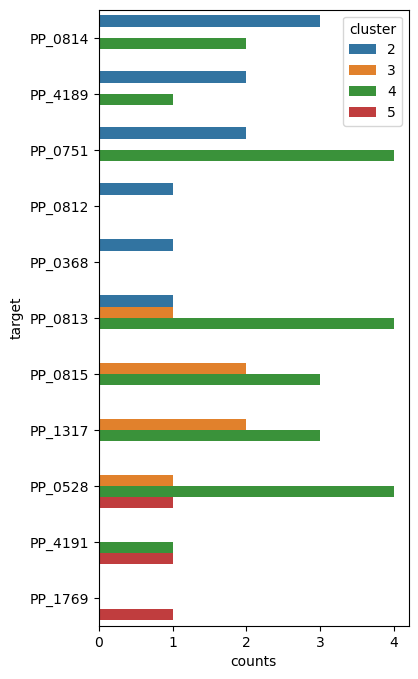

In [73]:
ct_df_list = []
for i, c in enumerate(counted_targets):
    ct_df_list.append(pd.DataFrame.from_dict(c, orient = 'index', columns=['counts']).reset_index(names = ['target']))
    ct_df_list[i]['cluster'] = i
ct_df = pd.concat(ct_df_list)
ct_df['cluster'] +=1
fig, ax = plt.subplots(figsize = (4,8))
sns.barplot(data = ct_df, x = 'counts', y = 'target', hue = 'cluster', palette = sns.color_palette('tab10'))

<Axes: xlabel='counts', ylabel='index'>

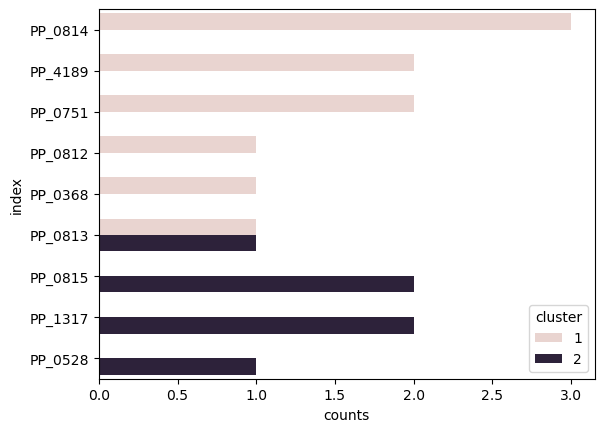

In [52]:
test = pd.DataFrame.from_dict(counted_targets[1], orient = 'index', columns=['counts']).reset_index()
test['cluster'] = 1
test2 = pd.DataFrame.from_dict(counted_targets[2], orient = 'index', columns=['counts']).reset_index()
test2['cluster'] = 2
test_both = pd.concat([test, test2])
test_both
sns.barplot(data = test_both, x = 'counts', y = 'index', hue = 'cluster')

### Do PCA and color by cluster/titer

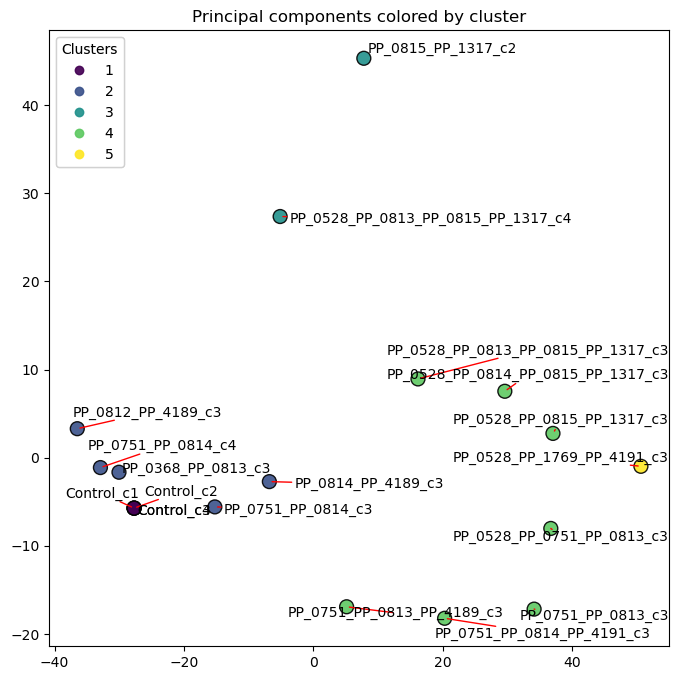

In [53]:
pca = PCA(n_components = 10)
cluster_pca = pca.fit_transform(X_cluster_df.loc[:,protein_measurements])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
legend1 = ax.legend(*sc.legend_elements(), loc = 'upper left', title = 'Clusters')
ax.add_artist(legend1)
ax.set_title('Principal components colored by cluster')
text_list = []
for i in range(len(cluster_pca)):
    text = ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))
    text_list.append(text)
adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1))

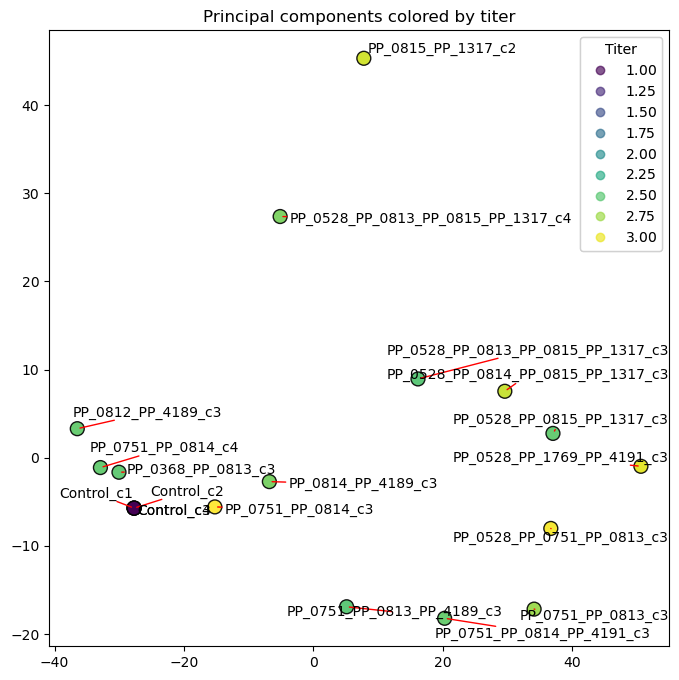

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['isoprenol'], s = 100, alpha = 0.9, edgecolors='k')
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Titer")
ax.add_artist(legend2)
ax.set_title('Principal components colored by titer')
text_list = []
for i in range(len(cluster_pca)):
    text = ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))
    text_list.append(text)
adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1))

### Do volcano plots on different clusters 

In [55]:
cluster_df = high_dist_df.copy()
cluster_df['cluster'] = fc
cluster_df

,Control_c1,Control_c2,Control_c3,Control_c4,PP_0528_PP_0813_PP_0815_PP_1317_c3,PP_0751_PP_0813_PP_4189_c3,PP_0368_PP_0813_c3,PP_0751_PP_0814_c4,PP_0528_PP_0815_PP_1317_c3,PP_0812_PP_4189_c3,PP_0814_PP_4189_c3,PP_0751_PP_0814_PP_4191_c3,PP_0528_PP_0813_PP_0815_PP_1317_c4,PP_0528_PP_1769_PP_4191_c3,PP_0528_PP_0751_PP_0813_c3,PP_0751_PP_0813_c3,PP_0528_PP_0814_PP_0815_PP_1317_c3,PP_0815_PP_1317_c2,PP_0751_PP_0814_c3,cluster
Control_c1,0.000000e+00,1.524708e-14,1.488662e-14,1.394677e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c2,1.524708e-14,0.000000e+00,1.995948e-14,2.030575e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c3,1.488662e-14,1.995948e-14,0.000000e+00,1.945751e-14,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
Control_c4,1.394677e-14,2.030575e-14,1.945751e-14,0.000000e+00,53.418162,47.911161,41.572987,43.974981,71.053725,41.336532,39.231299,60.163961,53.738394,84.117307,72.691981,72.306133,64.895898,70.257934,45.236311,1
PP_0528_PP_0813_PP_0815_PP_1317_c3,5.341816e+01,5.341816e+01,5.341816e+01,5.341816e+01,0.000000,47.810019,63.411959,67.141058,40.279962,66.257773,46.187796,51.044838,50.353732,51.938837,48.314872,53.085417,33.341206,58.309101,56.123516,4
PP_0751_PP_0813_PP_4189_c3,4.791116e+01,4.791116e+01,4.791116e+01,4.791116e+01,47.810019,0.000000,57.975739,60.623791,55.727712,64.639855,43.641511,40.720837,59.990491,65.758367,52.952913,47.633399,52.573154,69.971985,49.485047,4
PP_0368_PP_0813_c3,4.157299e+01,4.157299e+01,4.157299e+01,4.157299e+01,63.411959,57.975739,0.000000,50.718574,77.698898,38.895133,43.833117,69.008455,60.340924,91.565777,76.907585,76.414620,71.745845,73.195647,42.532621,2
PP_0751_PP_0814_c4,4.397498e+01,4.397498e+01,4.397498e+01,4.397498e+01,67.141058,60.623791,50.718574,0.000000,83.011049,49.220612,51.748930,72.049081,60.694941,94.640094,81.064321,80.440014,77.234798,76.367455,51.999600,2
PP_0528_PP_0815_PP_1317_c3,7.105372e+01,7.105372e+01,7.105372e+01,7.105372e+01,40.279962,55.727712,77.698898,83.011049,0.000000,82.782327,56.305139,52.559348,65.177660,45.183780,38.352979,47.484605,32.181429,67.742477,69.057976,4
PP_0812_PP_4189_c3,4.133653e+01,4.133653e+01,4.133653e+01,4.133653e+01,66.257773,64.639855,38.895133,49.220612,82.782327,0.000000,43.105034,74.571462,61.406890,96.066890,81.195244,83.375592,75.746419,74.533875,47.899857,2


In [56]:
clustered_lines = [line[:-3] for line in high_dist_df.columns]
clustered_lines = high_dist_df.columns
clustered_line_dict = dict(zip(clustered_lines, cluster_df.loc[:,'cluster']))
clustered_line_dict

{'Control_c1': 1,
 'Control_c2': 1,
 'Control_c3': 1,
 'Control_c4': 1,
 'PP_0528_PP_0813_PP_0815_PP_1317_c3': 4,
 'PP_0751_PP_0813_PP_4189_c3': 4,
 'PP_0368_PP_0813_c3': 2,
 'PP_0751_PP_0814_c4': 2,
 'PP_0528_PP_0815_PP_1317_c3': 4,
 'PP_0812_PP_4189_c3': 2,
 'PP_0814_PP_4189_c3': 2,
 'PP_0751_PP_0814_PP_4191_c3': 4,
 'PP_0528_PP_0813_PP_0815_PP_1317_c4': 3,
 'PP_0528_PP_1769_PP_4191_c3': 5,
 'PP_0528_PP_0751_PP_0813_c3': 4,
 'PP_0751_PP_0813_c3': 4,
 'PP_0528_PP_0814_PP_0815_PP_1317_c3': 4,
 'PP_0815_PP_1317_c2': 3,
 'PP_0751_PP_0814_c3': 2}

In [57]:
omics.loc['Control-R10_c1',:].name.split('-')[0]

'Control'

In [58]:
cluster_df = omics.copy()
cluster_df['line_name'] = [f"{x.split('-')[0]}_c{x[-1]}" for x in cluster_df.index.values]
cluster_df['is_control'] = ['ontrol' in x for x in cluster_df['line_name']]
cluster_df.loc[cluster_df['is_control'], 'line_name'] = cluster_df.loc[
    cluster_df['is_control'], 'line_name'].apply(lambda x: f'Control_c{x[-1]}')
cluster_df['has_cluster'] = cluster_df['line_name'].apply(lambda x: x in clustered_lines)

cluster_df = cluster_df[cluster_df['has_cluster']]

cluster_df['cluster'] = cluster_df['line_name'].apply(lambda x: clustered_line_dict[x])
# cluster_df = cluster_df.drop(['line_name', 'is_control', 'has_cluster'], axis = 1)

cluster_df

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol,line_name,is_control,has_cluster,cluster
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392,Control_c1,True,True,1
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367,Control_c1,True,True,1
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920,Control_c1,True,True,1
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284,Control_c1,True,True,1
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501,Control_c1,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_0814_PP_4189-R2_c3,1.107359,1.119107,1.000015,1.194510,1.162634,1.404364,0.986378,0.670907,1.510571,1.099229,...,0.986893,1.136518,0.942119,1.907045,0.837625,2.501831,PP_0814_PP_4189_c3,False,True,2
PP_0814_PP_4189-R3_c3,1.056136,0.240256,0.000000,0.058673,0.195026,0.752561,1.082981,1.461251,0.416789,0.752897,...,0.954108,1.135150,0.986804,1.770356,0.834674,2.538096,PP_0814_PP_4189_c3,False,True,2
PP_0815_PP_1317-R1_c2,1.290772,0.501705,0.639026,0.889245,0.501847,1.507286,0.578536,0.442818,0.872490,1.210034,...,1.330091,0.756013,1.538827,1.357455,1.083369,2.935459,PP_0815_PP_1317_c2,False,True,3


In [147]:
cluster_df['cluster'].value_counts()

cluster
1    54
4    21
2    15
3     6
5     3
Name: count, dtype: int64

In [149]:
np.array([0,1,2,3,4,5,6])+0.1

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1])

<Axes: xlabel='cluster', ylabel='isoprenol'>

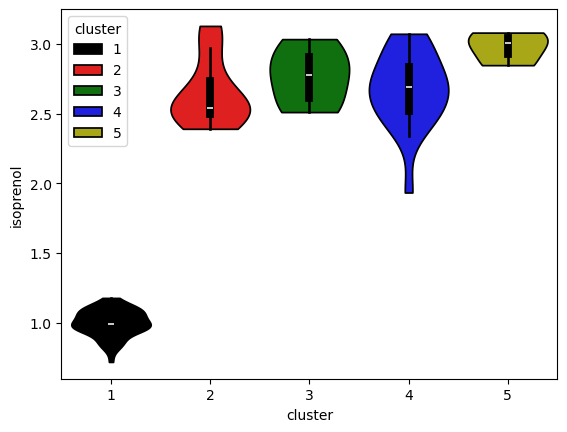

In [167]:
violin_palette = dict(zip([1,2,3,4, 5], ['k','r','g','b','y']))
sns.violinplot(data = cluster_df, y = 'isoprenol',x = 'cluster', hue = 'cluster', cut = 0, palette=violin_palette)


In [70]:
cluster_df.loc[:,'cluster'].value_counts()

cluster
1    54
4    21
2    15
3     6
5     3
Name: count, dtype: int64

In [59]:
from scipy import stats
rng = np.random.default_rng()

rvs1 = stats.norm.rvs(loc=6, scale=10, size=5000, random_state=rng)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=5000, random_state=rng)
stats.ttest_ind(rvs1, rvs2)[1]


1.0981735802250067e-08

In [60]:
#     #Annotate the points with protein names and adjust for label overlap
#     texts=[]
#     labels = [df_log2.iloc[i, 0] for i in range(len(fold_change))]
#     for i, label in enumerate(labels):
#         if fold_change[i] < -2 and p_values[i] > -np.log10(0.01):
#             text = plt.text(fold_change[i], p_values[i], label, fontsize=10) 
#             texts.append(text)
            
#     if texts:
#         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

In [ ]:
from scipy.stats import ttest_ind
!pip install adjustText
from adjustText import adjust_text

In [128]:
def volcano_plot(data1,
                 data2,
                 neglog10pval_thresh = 0.001,
                 log2fc_thresh = 3,
                 title_text = None,
                 label_flag = False,
                 select_proteins = None,
                 figsize = (10,10)
                ):
    # data1 and data2 are 
    common_columns = list(set(data1.columns).intersection(set(data2.columns)))
    df = pd.DataFrame(columns = ['prot', 'log2fc', 'neglog10p'], index = common_columns)
    for c in common_columns:
        l2fc = np.log2(np.mean(data2.loc[:, c])/np.mean(data1.loc[:,c]))
        nl10p = -np.log10(
            ttest_ind(data1.loc[:,c], data2.loc[:,c])[1]
        )
        df.loc[c,:] = [c, l2fc, nl10p]
        
    df.loc[:, 'significant'] = (
        (np.abs(df.loc[:,'log2fc'])>log2fc_thresh) & 
        (df.loc[:,'neglog10p']>neglog10pval_thresh)
    )

    df.loc[:, 'selected'] = False
    if select_proteins is not None:
        df.loc[:, 'selected'] = df['prot'].isin(select_proteins)

    df.loc[:, 'color'] = 'black'
    df.loc[df['significant'],'color'] = 'red'
    df.loc[df['selected'], 'color'] = 'blue'
                          
    fig, ax = plt.subplots(figsize = figsize)
    line_params = {'linestyle': '--', 'color': 'k', 'linewidth': 0.5} 
    ax.axvline(np.abs(log2fc_thresh), **line_params)
    ax.axvline(-np.abs(log2fc_thresh), **line_params)
    ax.axhline(np.abs(neglog10pval_thresh), **line_params)
    if title_text:
        ax.set_title(title_text)
    sns.scatterplot(data = df[df['color'] == 'black'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', alpha = 0.1, color = 'k')
    sns.scatterplot(data = df[df['color'] == 'red'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'r')
    sns.scatterplot(data = df[df['color'] == 'blue'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'b')

    
    ax.set_xlabel('log2(fold change)')
    ax.set_ylabel('-log10(p-value)')
    if label_flag:
        label_idx_sig = (
            (np.abs(df.loc[:,'log2fc'])>log2fc_thresh) & 
            (df.loc[:,'neglog10p']>neglog10pval_thresh)
        )
        label_idx = label_idx_sig | df['selected']
        text_x = df.loc[label_idx, 'log2fc'].values
        text_y = df.loc[label_idx, 'neglog10p'].values
        text_lbl = df.loc[label_idx, 'prot'].values
        
        text_list = [plt.text(text_x[i], text_y[i], text_lbl[i], fontsize = 10) for i in range(sum(label_idx))]
        
        
        adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1)) 
    else:
        select_proteins_label_idx = df['significant']
        sns.scatterplot(data = df[select_proteins_label_idx], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'b')

        select_proteins_x = df.loc[select_proteins_label_idx, 'log2fc'].values
        select_proteins_y = df.loc[select_proteins_label_idx, 'neglog10p'].values
        select_proteins_lbl = df.loc[select_proteins_label_idx, 'prot'].values
        select_proteins_text_list = [plt.text(select_proteins_x[i], select_proteins_y[i], select_proteins_lbl[i], fontsize = 10) for i in range(sum(select_proteins_label_idx))]
        adjust_text(select_proteins_text_list, arrowprops=dict(arrowstyle='-', color='blue', lw=1))
  
            
    return df

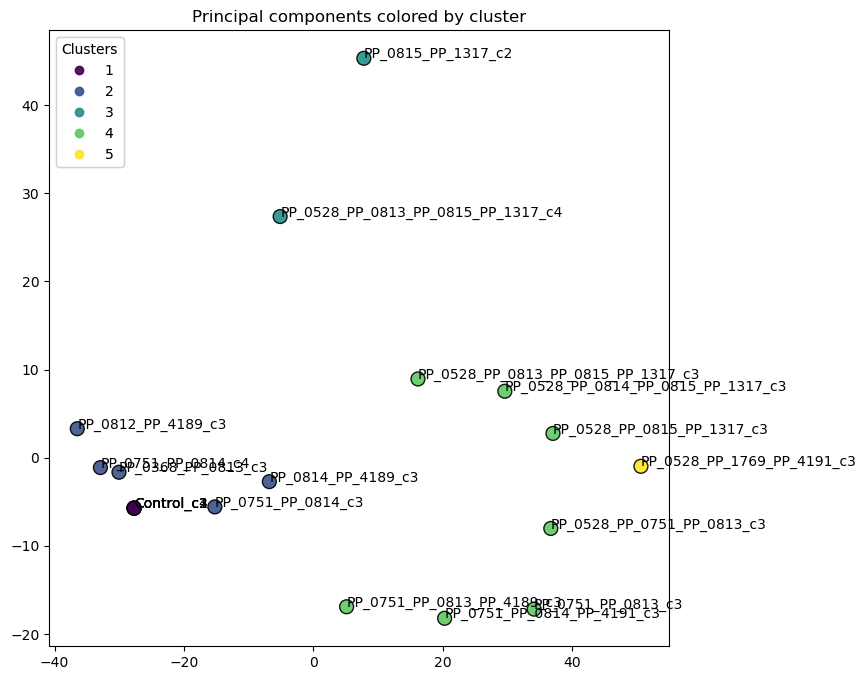

In [62]:
pca = PCA(n_components = 10)
cluster_pca = pca.fit_transform(X_cluster_df.loc[:,protein_measurements])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
legend1 = ax.legend(*sc.legend_elements(), loc = 'upper left', title = 'Clusters')
ax.add_artist(legend1)
ax.set_title('Principal components colored by cluster')
for i in range(len(cluster_pca)):
    ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))

In [131]:
cluster_df[cluster_df['cluster'] == 2]

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol,line_name,is_control,has_cluster,cluster
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
PP_0368_PP_0813-R1_c3,1.175377,0.405976,0.837969,0.989061,1.517267,1.877127,1.232083,0.283306,1.254789,0.933511,...,0.995014,0.800758,0.637548,1.296386,0.693630,2.624287,PP_0368_PP_0813_c3,False,True,2
PP_0368_PP_0813-R2_c3,1.245929,0.820711,0.728328,0.881401,1.105821,0.904454,1.094578,0.823467,0.811508,0.990253,...,1.133334,0.921578,1.047007,1.431667,0.930387,2.449524,PP_0368_PP_0813_c3,False,True,2
PP_0368_PP_0813-R3_c3,1.252274,0.690722,0.742180,0.782036,1.134673,1.014796,1.251221,0.896126,1.039800,0.979400,...,1.106898,0.946522,0.955738,1.493190,0.823972,2.475789,PP_0368_PP_0813_c3,False,True,2
PP_0751_PP_0814-R1_c3,1.081056,1.159897,0.769902,1.192756,2.498123,2.088474,0.738073,0.098861,1.224572,1.004839,...,0.689206,0.838959,0.403993,1.315905,0.654077,3.127784,PP_0751_PP_0814_c3,False,True,2
PP_0751_PP_0814-R1_c4,0.994088,0.695306,0.399683,1.443120,0.978156,0.689601,1.064640,0.640082,1.015966,1.194109,...,0.873637,1.907650,0.848515,1.522081,0.862250,2.523918,PP_0751_PP_0814_c4,False,True,2
PP_0751_PP_0814-R2_c3,1.109416,0.827616,0.497285,0.750144,0.922608,1.028404,0.960709,0.920346,0.686049,0.940589,...,0.937224,1.693971,0.993719,1.658077,1.015314,2.972795,PP_0751_PP_0814_c3,False,True,2
PP_0751_PP_0814-R2_c4,0.406845,0.861917,0.046731,0.092942,0.630813,1.144738,0.772672,1.087974,0.090655,0.624997,...,0.558968,1.888221,0.564751,1.137192,0.471651,2.671439,PP_0751_PP_0814_c4,False,True,2
PP_0751_PP_0814-R3_c3,1.131536,0.706560,0.447692,0.671823,1.126311,0.777191,1.141973,0.746186,1.049828,1.009706,...,0.939918,1.544090,0.727908,1.809558,0.929023,3.099380,PP_0751_PP_0814_c3,False,True,2
PP_0751_PP_0814-R3_c4,0.744262,0.499845,0.371199,1.067475,1.183529,0.706003,1.154557,0.777179,1.164438,0.844925,...,0.752999,1.584283,0.731508,1.335859,0.523416,2.390665,PP_0751_PP_0814_c4,False,True,2


In [133]:
ct_df[ct_df['cluster'] == 2]

,target,counts,cluster
0,PP_0814,3,2
1,PP_4189,2,2
2,PP_0751,2,2
3,PP_0812,1,2
4,PP_0368,1,2
5,PP_0813,1,2


(array([ 113,  155,  166,  260,  275,  438,  471,  480, 1181, 1395, 1459,
       1488, 1526, 1602, 1655, 1750, 1767, 1797, 1872]),)


,prot,log2fc,neglog10p,significant,selected,color
PP_2656,PP_2656,1.274966,1.773704,False,False,black
PP_4818,PP_4818,-0.064802,0.357188,False,False,black
PP_2902,PP_2902,-0.38656,0.424431,False,False,black
PP_2258,PP_2258,-1.434936,1.628489,False,False,black
PP_0186,PP_0186,-0.19139,0.605969,False,False,black
...,...,...,...,...,...,...
PP_0793,PP_0793,0.045919,0.201936,False,False,black
PP_1087,PP_1087,-0.153674,0.245591,False,False,black
PP_5078,PP_5078,-0.038303,0.255679,False,False,black
PP_2163,PP_2163,0.111148,0.307495,False,False,black


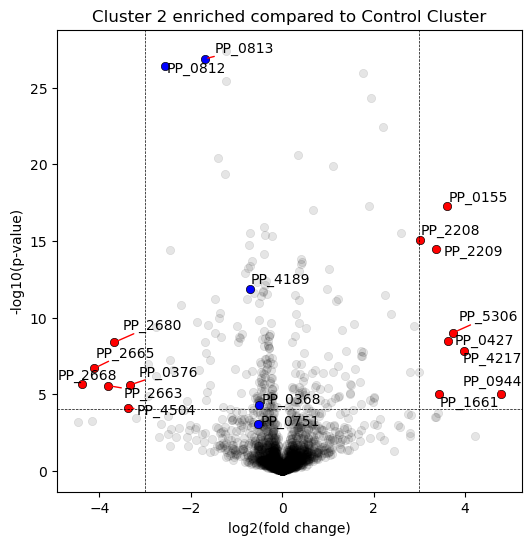

In [139]:
cluster_compare = 2
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    figsize=(6,6)
)

(array([ 113,  134,  154,  166,  275,  409,  419,  471,  543,  586,  598,
        733,  734,  833,  848,  878,  953, 1048, 1181, 1259, 1300, 1336,
       1395, 1420, 1441, 1502, 1526, 1655, 1680, 1767, 1797, 1862]),)


,prot,log2fc,neglog10p,significant,selected,color
PP_2656,PP_2656,2.079914,6.056127,False,False,black
PP_4818,PP_4818,0.340203,5.198289,False,False,black
PP_2902,PP_2902,0.764158,2.15795,False,False,black
PP_2258,PP_2258,1.329313,3.854483,False,False,black
PP_0186,PP_0186,0.655635,7.114583,False,False,black
...,...,...,...,...,...,...
PP_0793,PP_0793,0.194746,2.415298,False,False,black
PP_1087,PP_1087,0.814669,5.847492,False,False,black
PP_5078,PP_5078,0.170215,3.888161,False,False,black
PP_2163,PP_2163,0.443421,4.178583,False,False,black


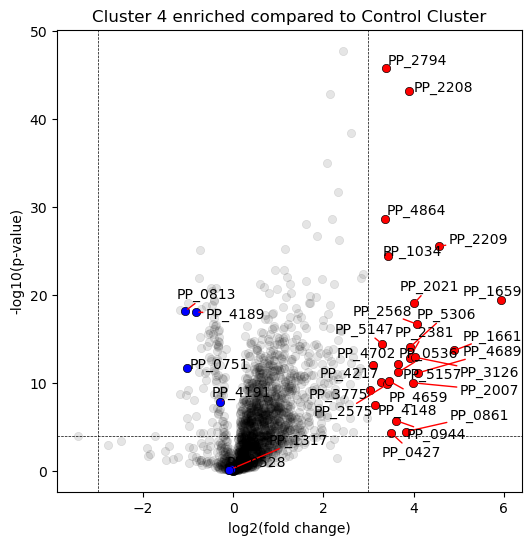

In [140]:
cluster_compare = 4
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    figsize=(6,6)
)

(array([   3,   21,   30,   84,  155,  202,  260,  277,  333,  380,  438,
        452,  498,  538,  543,  573,  593,  677,  697,  703,  707,  733,
        833,  848,  904,  987, 1042, 1068, 1074, 1087, 1093, 1217, 1316,
       1324, 1408, 1417, 1459, 1477, 1488, 1498, 1558, 1749, 1773, 1822]),)


,prot,log2fc,neglog10p,significant,selected,color
PP_2656,PP_2656,0.804948,0.70826,False,False,black
PP_4818,PP_4818,0.405004,2.653811,False,False,black
PP_2902,PP_2902,1.150718,1.716098,False,False,black
PP_2258,PP_2258,2.764249,3.042006,True,False,red
PP_0186,PP_0186,0.847025,4.947068,False,False,black
...,...,...,...,...,...,...
PP_0793,PP_0793,0.148827,0.623938,False,False,black
PP_1087,PP_1087,0.968343,4.177875,False,False,black
PP_5078,PP_5078,0.208517,2.360376,False,False,black
PP_2163,PP_2163,0.332273,1.506099,False,False,black


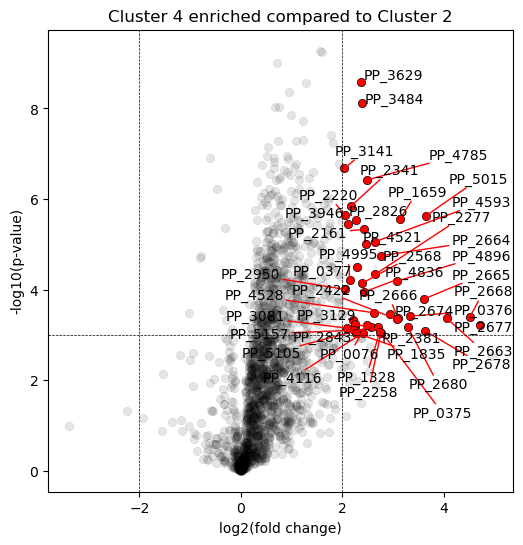

In [141]:

cluster_compare = 4
cluster_baseline = 2
title_text = f'Cluster {cluster_compare} enriched compared to Cluster {cluster_baseline}'

volcano_plot(
    cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=2,
    neglog10pval_thresh=-np.log10(0.001),
    label_flag = True,
    title_text=title_text,
    figsize = (6,6),
)

In [ ]:
cluster_A = 4
cluster_B = 1
title_text = f'Cluster {cluster_A} enriched compared to Control Cluster'

volcano_plot(
    cluster_df.loc[cluster_df['cluster'] == cluster_A, protein_measurements],
    cluster_df.loc[cluster_df['cluster'] == cluster_B, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text
)

In [ ]:
cluster_high = 3
high_from_cluster = cluster_df.loc[cluster_df['cluster'] == cluster_high, 'isoprenol'].sort_values(ascending = False).head(1).index.values[0]
high_from_cluster_linename = f'{high_from_cluster.split("-")[0]}_c{high_from_cluster[-1]}'
high_from_cluster_linename

title_text = f'Cluster {cluster_high} max strain: {high_from_cluster_linename} enriched compared to Control'

volcano_plot(
    cluster_df.loc[cluster_df['line_name'] == high_from_cluster_linename, protein_measurements],
    cluster_df.loc[cluster_df['is_control'], protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text
)

# cluster_df

### Visualize PCs 1, 2, and 3:
We can see that PC3 basically just separates the 3rd (green cluster)

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (5,10))
ax[0].scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
ax[0].set_title('Principal components colored by cluster')
ax[0].set_ylabel('PC2')
ax[1].scatter(cluster_pca[:,0], cluster_pca[:,2], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
ax[1].set_ylabel('PC3')
ax[1].set_xlabel('PC1')

### Plot explained variance:
3 PCs explain about 70% of the variance in the proteomics data among the highest titer strains.

In [ ]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')

In [ ]:
pca.components_.shape

### Plot loadings of first and second principal components

Each principle component has a 'loading' for each protein. That allows us to approximate the proteomics for a given strain as:

$[proteomics measurement] = [PC1 score] * [PC1 loading] + [PC2 score] * [PC2 loading] + ... + [PC_N score] * [PC_N loading]$

So, by looking at the loadings of each principle component, we can can figure out what proteins are most important. For instance, going from the control points to cluster 3 means moving primarily along the PC1 axis. So, if we look at the highest loadings of PC1, we'd expect these to increase from the control to cluster 3. 

In [ ]:
cluster_pca_loading_df = pd.DataFrame(data = pca.components_, columns=protein_measurements, index=[f'pc_{i}' for i in range(1, 1+pca.n_components_)])
cluster_pca_loading_df.loc['pc_1',:].sort_values(ascending = False).head(5)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
for i, a in enumerate(ax):
    sns.histplot(data = cluster_pca_loading_df.iloc[i,:], ax = a)
    
fig.tight_layout()

In [ ]:
n_to_plot = 5
fig, ax = plt.subplots(2,2, figsize = (10,10))
for i, pc in enumerate(['pc_1', 'pc_2']):#, 'pc_3']):
    sorted_pc = cluster_pca_loading_df.loc[pc,:].sort_values()
    # sns.barplot(data = sorted_pc[:10], x = sorted_pc.values[:10], y = sorted_pc.index[:10],   ax = ax[i,0])
    sns.barplot( x = sorted_pc.values[:n_to_plot], y = sorted_pc.index[:n_to_plot],   ax = ax[i,0])
    # sns.barplot( x = sorted_pc.values[-n_to_plot::-1], y = sorted_pc.index[-n_to_plot::-1],   ax = ax[i,1])
    sns.barplot( x = sorted_pc.values[-1:-n_to_plot-1:-1], y = sorted_pc.index[-1:-n_to_plot-1:-1],   ax = ax[i,1])

    ax[i,0].set_ylabel(f'loadings for {pc}')
    
ax[0,0].set_title(f'{n_to_plot} most negative loadings')
ax[0,1].set_title(f'{n_to_plot} most positive loadings')
fig.tight_layout()